In [24]:
%matplotlib inline

import pandas as pd
from datetime import timedelta
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import *
import seaborn as sb

## 1. Exploratory Analysis and Data Preparation

In [2]:
df = pd.read_csv("Upwork 20160117.csv")
df.columns = [x.lower().replace(" ", "_") for x in df.columns]
df = df.set_index("date")
df.index = pd.to_datetime(df.index, format="%m/%d/%Y")

#### 1. Buy Swing = High0 - Open0
#### 2. Sell Swing = Open0 - Low0

In [3]:
day_after_max_buy_swing = df.loc[df["buy_swing"] == df["buy_swing"].max()].index + timedelta(days=1)
df.loc[day_after_max_buy_swing]

,open,high,low,close,direction,buy_swing,sell_swing
date,,,,,,,
2015-08-26,5205,5230,5007,5192,DOWN,25,198


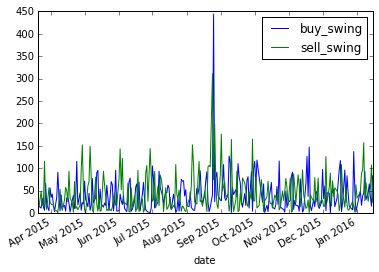

In [4]:
df[["buy_swing", "sell_swing"]].plot()

From the graph below I can conclude that the stock price does not follow an exponential decline, just a trending decline, I won't use log values, but maybe first differences to take care of the downward trend

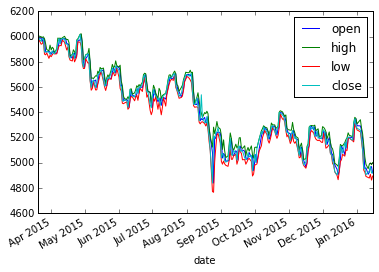

In [5]:
df[["open", "high", "low", "close"]].plot()

In [6]:
cols_to_difference = ["open", "high", "low", "close"]
differenced_cols = []
for col in cols_to_difference:
    name = col + "_1_diff"
    df[name] = df[col].diff()
    differenced_cols.append(name)

Now it seems much better (the graph bellow). We have a stationary data of daily prices, the downward trend is differenced out and the variability of the underlying stock remaims. Now a model can be fitted.

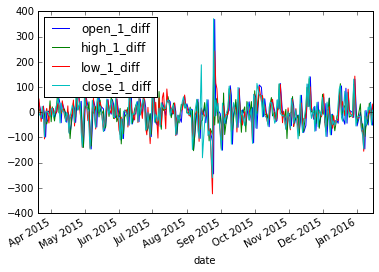

In [7]:
df[differenced_cols].plot()

One way to examine the relationship in the stock is to plot the variable againt its lag value. Lets create a lagged value column from the differenced "open_1_diff" and plot these two columns.

In [20]:
df["low_diff_lagged"] = df["low_1_diff"].shift()

There's no obvious relationship, it seems that the observations are evenly distributed, but lets fit a model and see its accuracy.

### Let's build the dataframe so that it fits the needed structure

- Rows Should contain: todays open, previous open lags, yesterdays high/low/close and buy and sell swing. Further lags won't be added, but selected based on the model.

- For modelling purposes todays high/low/close/buy&sell swing aren't needed (unknowns), so I'll shift these columns to have todays open and previous days observations for the other columns in the same row.

In [11]:
cols_to_shift = ["high_1_diff", "low_1_diff", "close_1_diff", "buy_swing", "sell_swing"]

for col in cols_to_shift:
    col_name = col + "_shifted"
    df[col_name] = df[col].shift(1)

In [31]:
df["tomorrows_low"] = df["low"].shift(-1)
df["yesterdays_low"] = df["low"].shift()

Let's make some plots to examine the relationship between tomorrow's low with today's open and yesterday's buy/sell swing

In the plot below there's almost perfect linear relationship between tomorrow's low and today's open. It seems that todays open should be a good predictor of tomorrow's low. 

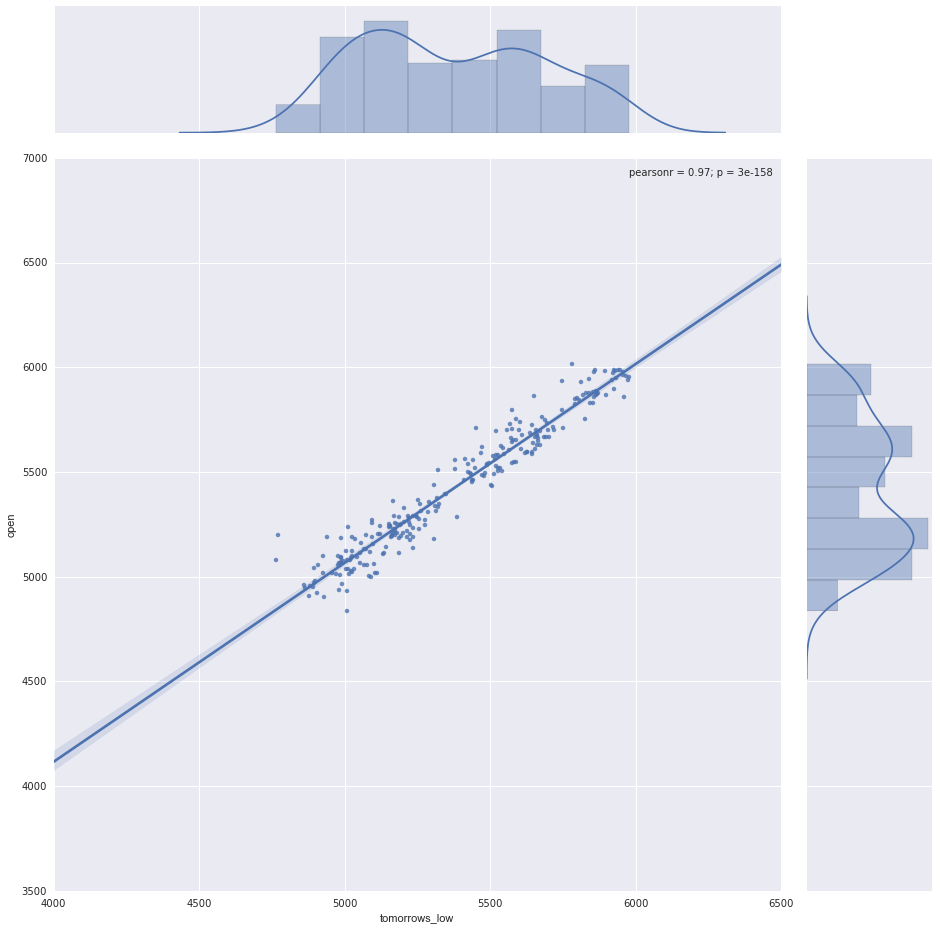

In [28]:
sb.jointplot("tomorrows_low", "open", df, kind='reg', size=13)

Here tomorrow's low is compared to yesterdays buy swing. Again a relationship is obvious, but not as great as the relationship with todays open.

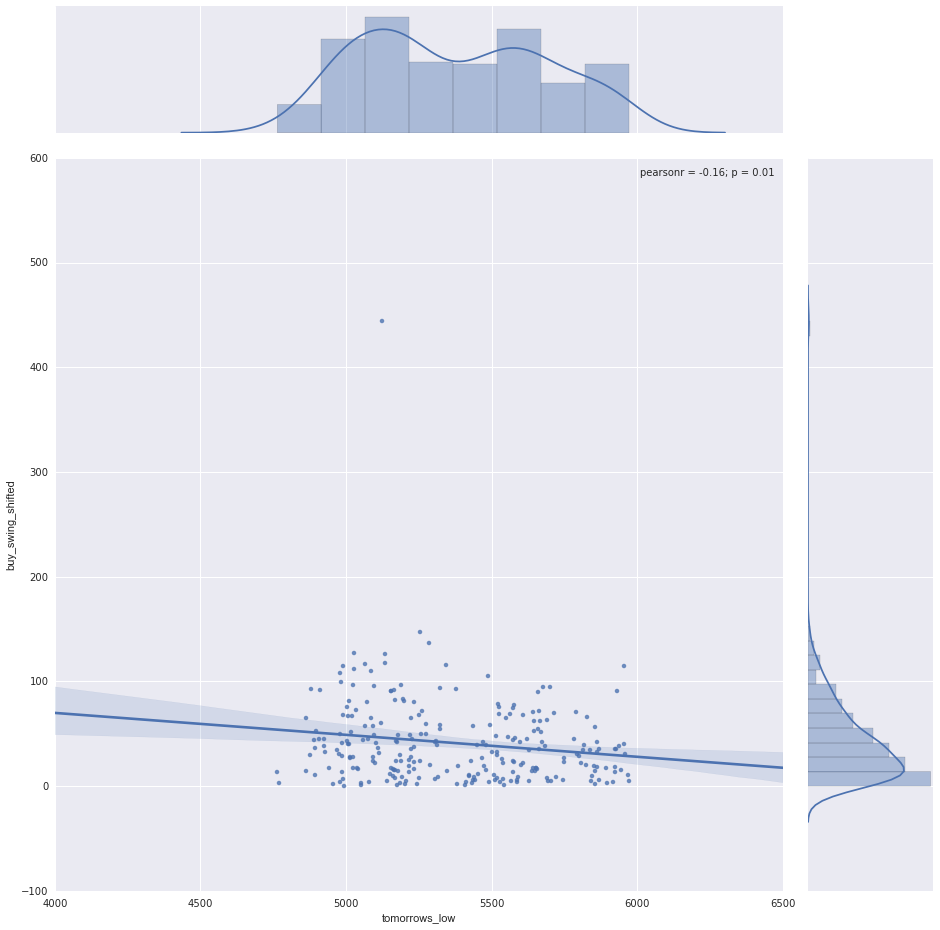

In [29]:
sb.jointplot("tomorrows_low", "buy_swing_shifted", df, kind='reg', size=13)

Here tomorrow's low is compared to yesterday's sell swing. Again a linear relationship is visible, but not too strong. Also, there's one outlier where the sell swing is above 300.

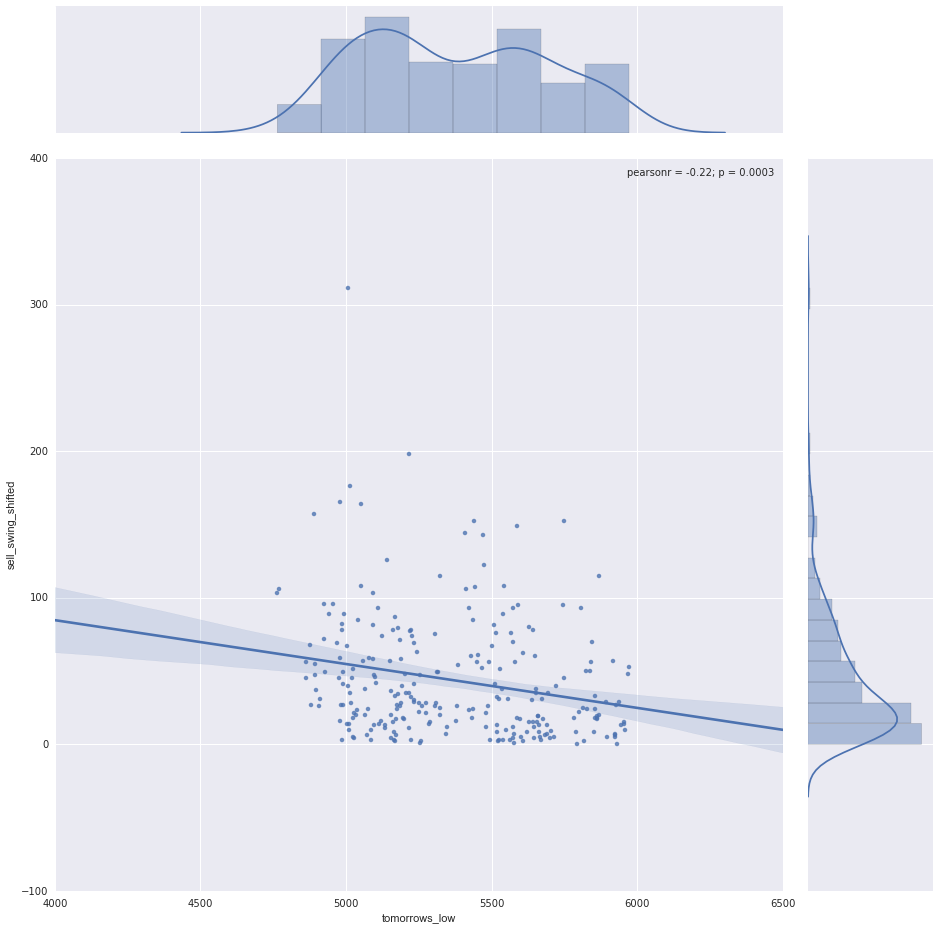

In [30]:
sb.jointplot("tomorrows_low", "sell_swing_shifted", df, kind='reg', size=13)

## 2. Build Model

- Let's regress tomorrow's low against todays open and yesterdays buy/sell swing

In [32]:
cols_for_model = ["yesterdays_low", "open", "buy_swing_shifted", "sell_swing_shifted"]
df_model = df[cols_for_model].dropna()

In [33]:
df_to_forecast = df_model[:-4]

In [34]:
model = VAR(df_to_forecast)
model.select_order()

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         32.63        32.69    1.482e+14        32.65
1        19.55*       19.85*   3.104e+08*       19.67*
2         19.62        20.15    3.330e+08        19.84
3         19.67        20.43    3.487e+08        19.98
4         19.75        20.75    3.799e+08        20.16
5         19.80        21.03    3.973e+08        20.30
6         19.66        21.13    3.467e+08        20.25
7         19.68        21.38    3.538e+08        20.37
8         19.74        21.68    3.779e+08        20.52
9         19.77        21.94    3.899e+08        20.65
10        19.83        22.23    4.140e+08        20.80
11        19.83        22.47    4.181e+08        20.90
12        19.85        22.73    4.276e+08        21.01
13        19.87        22.98    4.400e+08        21.13
14        19.94        23.28    4.741e+08        21.29
15        

{'aic': 1, 'bic': 1, 'fpe': 1, 'hqic': 1}

In [35]:
results = model.fit(1)
lag_order = results.k_ar

In [40]:
low_forecasts = []
counter = 0
for prediction in results.forecast(df_to_forecast.values[-lag_order :], 5):
    if counter != 0:
        low_forecasts.append(prediction[0])
    counter += 1
print len(low_forecasts)

4


## 3. Validate Model

Original Values

In [44]:
true_observations = df[-4:]["low"]

#### Here are the predictions vs. the observed values. 

In [52]:
cols = ["observed", "predicted"]
df_comparison = pd.DataFrame(true_observations)
df_comparison["predicted"] = low_forecasts
df_comparison["predicted"] = df_comparison["predicted"].round()
df_comparison.columns = cols
df_comparison

,observed,predicted
date,,
2016-01-12,4877,4860
2016-01-13,4906,4868
2016-01-14,4861,4876
2016-01-15,4893,4883
